# Individual Data Generation Example
For the individual data generation, the probability to have a true positive label is dependent on the previous predictions for the individual. The number of positive and negative predictions defines, whether individuals move towards the positive or negative cluster. The negative label is 0 here, therefore only positive decisions have an impact on $X$.

In [1]:
import sys
import numpy as np
sys.path.append("../")

from sklearn.linear_model import LogisticRegression

from ltf.ltf_plot import LongTermFairnessPlot
from ltf.ltf_data.individual_data_generator import IndividualDataGenerator
from ltf.ltf_metric.aif360_metric import AifLongTermMetric

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The helper class is necessary to use sklearn with the ltf framework.
class CLF:
    def __init__(self, clf=LogisticRegression()):
        self.c = clf
    def predict(self, X, X_s):
        return self.c.predict(X)
    def fit(self, X, X_s, y):
        self.c.fit(X, y)   

## 1. Unconstrained Example

In [4]:
# The data generator.
generator = IndividualDataGenerator(mean_pos=[0, 1],
                                    mean_neg=[12, 11],
                                    num_positive_label=50,
                                    num_negative_label=50,
                                    discrimination_factor=.9)

In [5]:
# The long term metric with default options (disparate impact and base rate).
metric = AifLongTermMetric()

In [6]:
# The clf.
clf = CLF()

In [7]:
# The long term plot generator.
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 14], y_lim=[-1, 15])

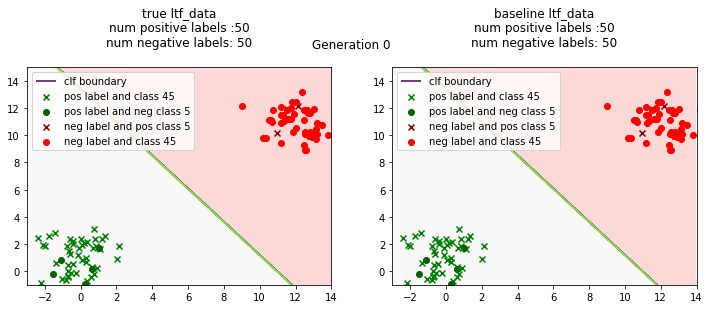

In [8]:
# Initialize the data and plot the first generation.
l.init_data()
l.plot_step()

On initialization, both left and right figure are the same. The classifier is the same in both pipelines and only trained on the true data in the first iteration.

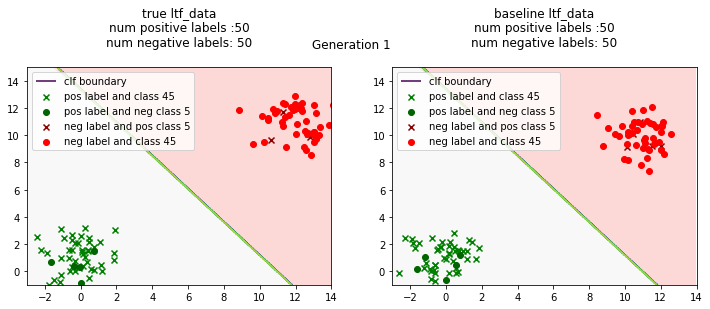

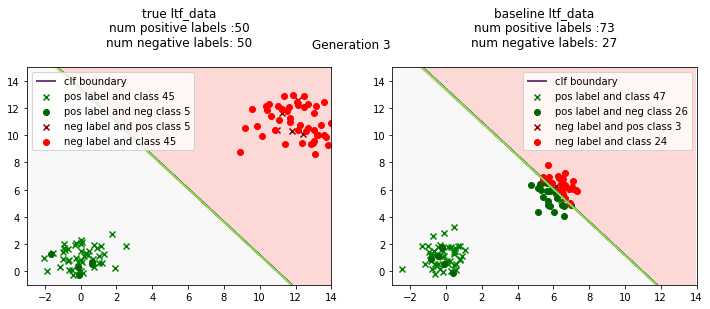

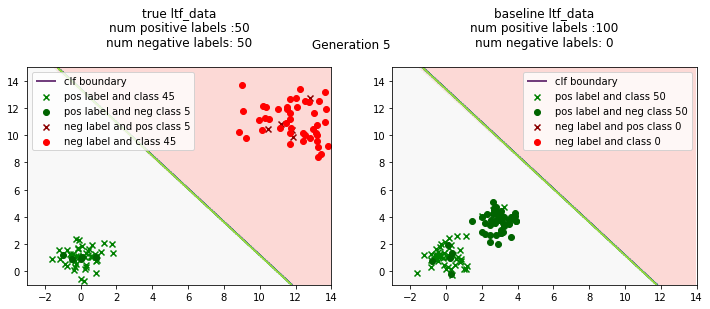

In [9]:
# Run 6 generations and plot every second step.
for i in range(6):
    l.run_step()
    l.run_baseline_step()
    
    if i % 2 == 0:
        l.plot_step()

After 6 iterations, the proportions in the true data (left column) did not change. In the baseline data (right column), all points have a true positive label now.

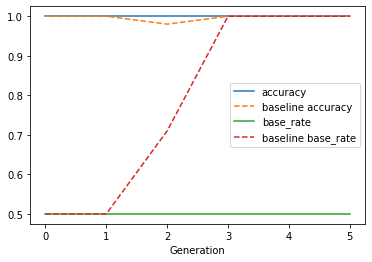

In [10]:
# Plot the metrics for the six generations.
l.plot_ltf(metric._metrics)

In the true data, accuracy and base rate are constant through all generations. In the baseline pipeline, the base rate improves constantly, and the accuracy drops for a short period of three generations. The accuracy decrease is for instance visible in the plot of generation 3. Some individuals reach the data generating boundary (the border between red and white area) but are labeled negative because the learned boundary (green line) does not perfectly match the true boundary.

The consequence of this data generation is that although the decision function perfectly separates the points, it  fails to increase the overall number of true positive individuals and therefore does not unleash the full potential in the data. The next example shows the same setup with a constrained decision boundary.

## 2. Constrained Example 
The unconstrained example showed, that a perfect decision boundary might not unleash the full potential of each individual. This section shows that a constrained decision function might be better, but still does not unleash the full potential assuming the underlining setting of data generation where only individuals benefit from decisions.

The data generation for this example is the same as before, except that the local variance is smaller now (the local variance is the deviation of the features $X_i ^{(t)}$ from the previous features $X_i ^{(t-1)}$ of individual $i$). 

Hence, the probability for individuals to randomly cross the decision boundary is much slower. This avoids,  that individuals move to far away from their initial position and randomly cross the decision boundary.

In [11]:
# Fair artificial decision rule. The artificial decision rule is necessary, to produce the desired result...
class FairCLF:
    def predict(self, X, X_s):
        pred = [5, -12] @ X.T + 50
        
        pred[pred>0] = 1
        pred[pred<0] = 0
        
        return np.sign(pred)
    def fit(self, X, X_s, y):
        pass

In [12]:
# New generator with smaller local variance.
generator = IndividualDataGenerator(mean_pos=[0, 1],
                                    mean_neg=[12, 11],
                                    cov_neg= [[10, 0],[0, 7]], 
                                    num_positive_label=50,
                                    num_negative_label=50,
                                    discrimination_factor=.9,
                                    local_variance=[[0.001, 0], [0, 0.001]])

In [13]:
# The clf.
clf = FairCLF()

In [14]:
# LTF plot.
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 20], y_lim=[-1, 20])

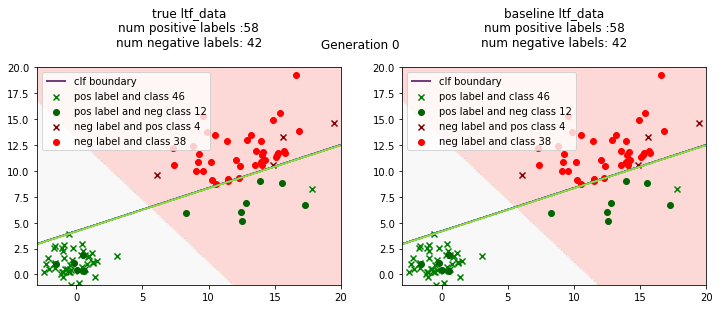

In [15]:
# Plot the initial data.
l.init_data()
l.plot_step()

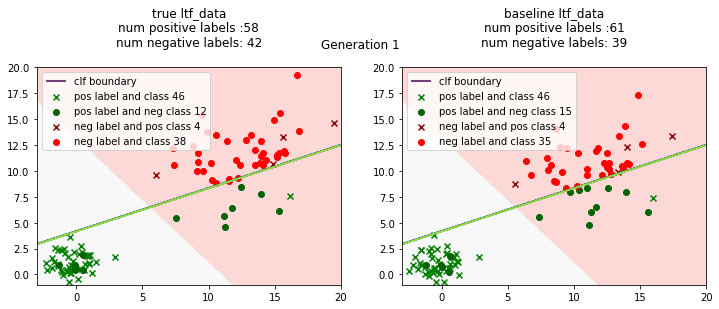

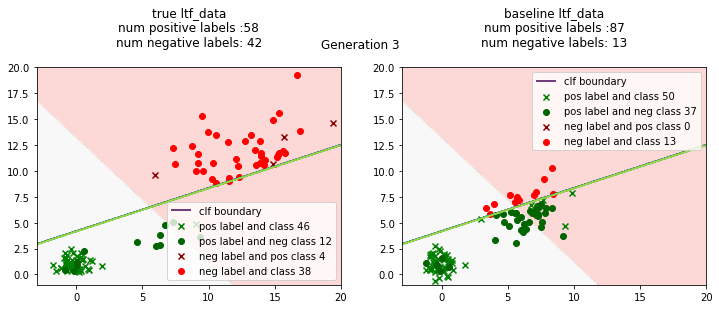

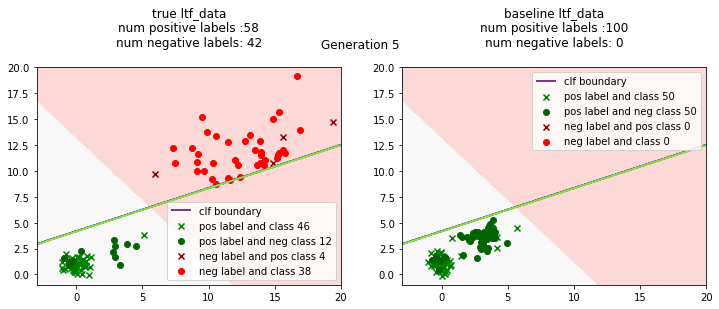

In [16]:
# Run six generations and plot every second step.
for i in range(6):
    l.run_step()
    l.run_baseline_step()
    
    if i % 2 == 0:
        l.plot_step()

Only the individuals who were positive labeled in the first iteration have moved towards the positive cluster in the true data. 

In the baseline data all points moved towards the positive cluster again.

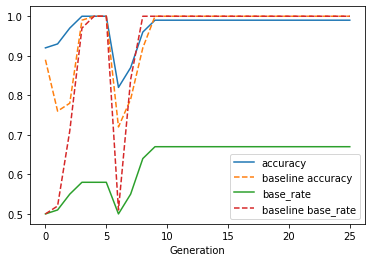

In [17]:
# Run 20 generations.
l.run(20)
l.plot_ltf(metric._metrics)

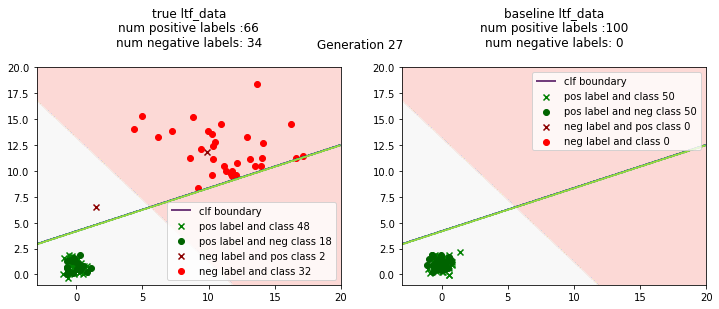

In [18]:
# Plot the data points after 100 generations with lower variance.
l.plot_step()

In the baseline data, all individuals have a positive label after some time again. In the true data, a few individuals were given a chance and only those moved towards the positive cluster.

Because of the low variance, only those individuals who were lucky in the first generation moved to the positive cluster.

Note, that there is a large concentration at the center of the positive cluster now due the small local variance.

## 3. Conclusion
The purpose of this example was, to show that a perfect decision function does not always result in perfect fairness (at least if measured from a long-term perspective).